# CMAPSS using Deep Neural Networks
This notebook contains a minimal example of DNN for the CMAPSS datasets, including
1. Updated and refactored data preprocessing scripts
2. NN architecture and training steps

```
Author: CSN
Last modified: 20221102
```

In [1]:
# Load the "autoreload" extension so that code can change
%load_ext autoreload
# Always reload modules so that as you change code in src, it gets loaded
%autoreload 2

import os

import matplotlib.pyplot as plt
import numpy as np
# Import all relevant libraries
import pandas as pd
from utils.utils import (clean_test_dataf, clean_train_dataf, lag_dataframe,
                         scale_test_dataf, scale_train_dataf)

In [2]:
filename = './data/train_FD001.txt'

# Set the column names for the raw CMAPSS data
columns = ['machine_number', 'uptime', 'setting_1', 'setting_2', 'setting_3']
sensor_measurements = [f'sensor_{i:02d}' for i in range(1, 25)]
columns += sensor_measurements

# Read plain text file
df = pd.read_csv(filename, sep=" ", names=columns, index_col=False)

In [3]:
# Supplementary cell to write data for PCS-CMAPSS
def add_train_RUL(grp):
    # Apply clipping to RUL based on uptime
    grp['RUL'] = (grp['uptime'].max() - grp['uptime'] + 1)
    # Apply clipping to RUL
    grp['RUL'].clip(upper=125, inplace=True)

    return grp

def add_test_RUL(grp):
    grp['RUL'] += grp['uptime'].max() - grp['uptime']
    # Apply clipping to RUL
    grp['RUL'].clip(upper=125, inplace=True)
    return grp


# Verify the number of columns in the training df
(df
  .sort_values(by=['machine_number', 'uptime'], axis=0)
  .groupby('machine_number', group_keys=True)
  .apply(add_train_RUL)
).to_csv('./data/train_FD001.csv', index=False)
pd.read_csv('./data/train_FD001.csv')["RUL"].min()

1

In [4]:
# Now load the test set and apply the same preprocessing
df_test = pd.read_csv('./data/test_FD001.txt', sep=" ", names=columns, index_col=False)

# Load the y_test
y_test = pd.read_csv('./data/RUL_FD001.txt', names=['RUL'])
y_test['machine_number'] = y_test.index + 1

# Join the test X and label dataframes
df_test = df_test.join(y_test.set_index('machine_number'), on='machine_number')

In [14]:
# Supplementary cell to write data for PCS-CMAPSS demo
def add_test_RUL(grp):
    # RUL test can be greater than max(uptime), so recompute RUL accordingly
    grp['RUL'] += grp['uptime'].max() - grp['uptime']
    # Apply clipping to RUL
    grp['RUL'].clip(upper=125, inplace=True)
    return grp

# Verify the number of columsn in the test set
(df_test
  .sort_values(['machine_number', 'uptime'], axis=0)
  .groupby('machine_number', group_keys=True)
  .apply(add_test_RUL)
).to_csv('./data/test_FD001.csv', index=False)
df_bla = pd.read_csv('./data/test_FD001.csv')

In [15]:
df_bla[df_bla.machine_number == 1]["RUL"]

0     125
1     125
2     125
3     125
4     125
5     125
6     125
7     125
8     125
9     125
10    125
11    125
12    125
13    125
14    125
15    125
16    125
17    125
18    124
19    123
20    122
21    121
22    120
23    119
24    118
25    117
26    116
27    115
28    114
29    113
30    112
Name: RUL, dtype: int64

In the next cell we preprocess all the data using the `pandas` pipeline functionality.

In [8]:
num_lags = 30

# Run pre-processing on train set
clean_df = (df
            .pipe(clean_train_dataf, rejected_features=rejected_features)
            .drop(columns=['uptime'])
            )
# Split this pipe step to store scaler for later reuse
clean_df, scaler = clean_df.pipe(scale_train_dataf)
clean_df = clean_df.pipe(lag_dataframe, num_lags=num_lags)

# Run pre-processing on test set
clean_df_test = (df_test
                 .pipe(clean_test_dataf, rejected_features=rejected_features)
                 .drop(columns=['uptime'])
                )
clean_df_test = clean_df_test.pipe(scale_test_dataf, scaler=scaler)
clean_df_test = clean_df_test.pipe(lag_dataframe, num_lags=num_lags)

Now we construct our train, test, and validation sets.

In [9]:
x_train = clean_df.copy()
# x_train = clean_df[(clean_df['machine_number'] >= 1) & (clean_df['machine_number'] <= 50)].copy()
y_train = x_train.pop('RUL').astype(float)

x_test = clean_df_test.copy()
# x_test = clean_df_test[(clean_df_test['machine_number'] >= 1) & (clean_df_test['machine_number'] <= 50)].copy()
y_test = x_test.pop('RUL').astype(float)

if False:
    x_train.to_parquet('./data/x_train.parquet.gzip', compression='gzip')
    x_test.to_parquet('./data/x_test.parquet.gzip', compression='gzip')
    y_train.to_csv('./data/y_train.csv', index=False)
    y_test.to_csv('./data/y_test.csv', index=False)

# Drop 'machine_number' from the train/test
x_train_id = x_train.pop('machine_number')
x_test_id = x_test.pop('machine_number')

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# # Reserve 20% samples for validation
# val_rows = int(0.2*len(x_train))
# x_val = x_train.iloc[-val_rows:]
# y_val = y_train.iloc[-val_rows:]
# x_train = x_train.iloc[:-val_rows]
# y_train = y_train.iloc[:-val_rows]

# Training and evaluation
This section contains a basic MLP model and training procedure

In [10]:
def root_mean_squared_error(y_true, y_pred):
    # Define an rms loss function
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

def scheduler(epoch, lr):
    # Define a custom scheduler to vary learning rate based on epoch
    # Based on: https://doi.org/10.1016/j.ress.2017.11.021, page 5
    if epoch < 100:
      return lr
    else:
      lr = 1e-4
      return lr

In [11]:
# Create the model using the functional API approach
num_features = x_train.shape[1]
inputs = keras.Input(shape=(num_features,))
x = layers.Dense(500, activation="relu")(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(400, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="regress_model")

model.compile(
    loss=root_mean_squared_error,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mse', 'mae', 'mape']
)

2022-11-02 14:12:18.079445: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# Create callback for scheduling learning rate
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(
    x=x_train,
    y=y_train,
    epochs=10,
    # Suppress logging.
    # verbose=0,
    validation_data=(x_val, y_val),
    callbacks=[callback],)

Epoch 1/10
441/441 [==============================] - 2s 4ms/step - loss: 17.9396 - mse: 614.5609 - mae: 17.9396 - mape: 32.9852 - val_loss: 11.7223 - val_mse: 227.5367 - val_mae: 11.7223 - val_mape: 18.6030 - lr: 0.0010
Epoch 2/10
441/441 [==============================] - 2s 4ms/step - loss: 13.4802 - mse: 313.1044 - mae: 13.4802 - mape: 22.7027 - val_loss: 10.2476 - val_mse: 183.9130 - val_mae: 10.2476 - val_mape: 17.0519 - lr: 0.0010
Epoch 3/10
441/441 [==============================] - 2s 4ms/step - loss: 13.2045 - mse: 304.9885 - mae: 13.2045 - mape: 21.3335 - val_loss: 10.4452 - val_mse: 188.9828 - val_mae: 10.4452 - val_mape: 15.9565 - lr: 0.0010
Epoch 4/10
441/441 [==============================] - 2s 3ms/step - loss: 12.8979 - mse: 294.3171 - mae: 12.8979 - mape: 20.7008 - val_loss: 10.4460 - val_mse: 196.8980 - val_mae: 10.4460 - val_mape: 16.0508 - lr: 0.0010
Epoch 5/10
441/441 [==============================] - 2s 3ms/step - loss: 12.7307 - mse: 285.0035 - mae: 12.7307 - m

In [13]:
def plot_loss(history):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot(history.history['loss'], label='train_loss')
    axs[0].plot(history.history['val_loss'], label='val_loss')
    axs[1].plot(history.history['mse'], label='train_mse')
    axs[1].plot(history.history['val_mse'], label='val_mse')
    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend()
        ax.grid(True)
    axs[0].set_ylabel(' RUL')
    axs[1].set_ylabel('MSE RUL')

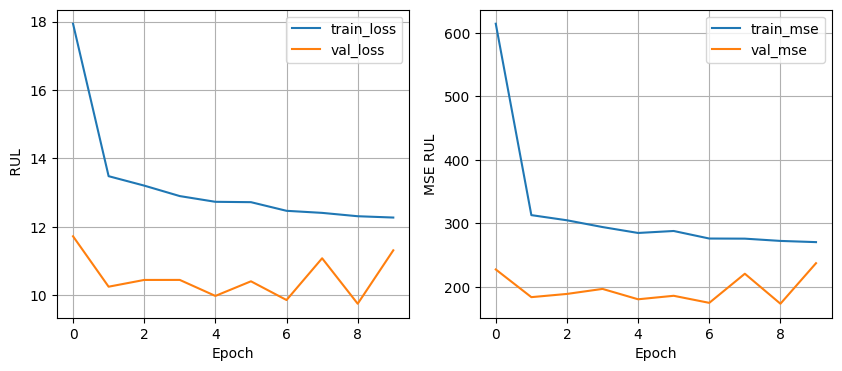

In [14]:
plot_loss(history)
plt.show()

# Visualise prediction on the test datasets

Here, we run a prediction on the test set, which the model has not seen before. We also visualise a subset of the predictions against the ground truth as a sanity check.

47/47 [==============================] - 0s 1ms/step


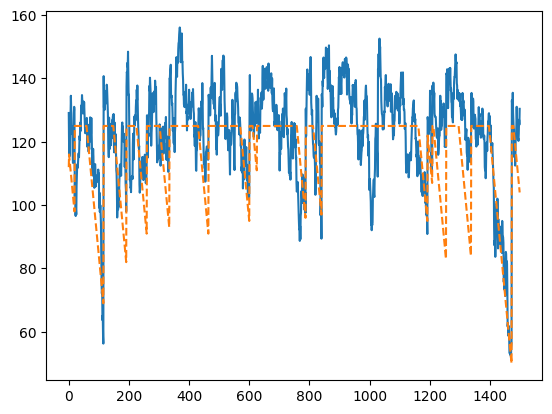

In [15]:
ind_ = 1500
plt.plot(model.predict(x_test[:ind_]))
plt.plot(y_test.iloc[:ind_].to_numpy(), '--')
plt.show()

# Evaluate prediction on the test datasets

In [16]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test)
print("test loss, test mse, test mae, test mape:", results)
print(f"test rmse {np.sqrt(results[1]):.4f}")

Evaluate on test data
316/316 [==============================] - 1s 2ms/step - loss: 12.6366 - mse: 271.7288 - mae: 12.6366 - mape: 14.5257
test loss, test mse, test mae, test mape: [12.636624336242676, 271.7287902832031, 12.636624336242676, 14.52569580078125]
test rmse 16.4842


## Note
It is a good practice to re-train the model multiple times and evaluate the mean and standard deviation of the rmse. This is due to the randomness of the initialisations as well as the dropout rate.